# 0. Заголовок и цель

Markdown

название проекта

что решаем: предсказание alpha (0..255), метрика MSE

данные: MAGICK (train), Kaggle test (orig_1024)

## 1. Импорты и глобальные настройки

Импорты, настройки PIL, базовые зависимости

In [1]:
import os
import io
import sys
import base64
import random
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode

Image.MAX_IMAGE_PIXELS = None

Все параметры меняются здесь

In [2]:
Image.MAX_IMAGE_PIXELS = None

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.set_float32_matmul_precision("high")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# пути
TRAIN_CSV = Path("data/splits/train.csv")
VAL_CSV   = Path("data/splits/val.csv")
TEST_ROOT = Path("data/test_dataset/orig_1024")  # твой тест Kaggle
MODEL_DIR = Path("outputs/experiments/exp_001")
MODEL_DIR.mkdir(parents=True, exist_ok=True)


TRAIN_SIZE = (512, 512)
VAL_SIZE   = (1024, 1024)
TRAIN_BATCH = 4
VAL_BATCH   = 1

LIMIT_DATA = 30
   
NUM_EPOCHS = 10
LR = 1e-4
RUN_TRAINING = True

## 2. Датасеты и аугментации


In [ ]:
class CsvAlphaDataset(Dataset):
    """
    Ожидает CSV с колонками:
      - image_path
      - alpha_path
    Возвращает dict как в baseline:
      {"img": tensor, "mask": tensor}
    """
    def __init__(self, csv_path: Path, size=(1024, 1024), normalize=True, augment=None, limit=LIMIT_DATA):
        self.csv_path = Path(csv_path)
        self.df = pd.read_csv(self.csv_path)

        if limit is not None:
            self.df = self.df.head(int(limit)).reset_index(drop=True)
            
        self.size = size
        self.augment = augment

        # ВАЖНО: Если есть augment (train), то augment делает crop до crop_size,
        # и НЕ нужно делать Resize до size - это размывает края альфы!
        # Для val/test (augment=None) делаем Resize до size
        use_resize = (augment is None)

        # Трансформы как в baseline
        if normalize:
            transform_list = []
            if use_resize:
                transform_list.append(transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR))
            transform_list.extend([
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  # RGB -> [-1, 1]
            ])
            self.image_transforms = transforms.Compose(transform_list)
        else:
            transform_list = []
            if use_resize:
                transform_list.append(transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR))
            transform_list.append(transforms.ToTensor())  # [0,1]
            self.image_transforms = transforms.Compose(transform_list)

        # Маска/альфа: нам важно сохранить значения 0..1 (без Normalize)
        mask_transform_list = []
        if use_resize:
            mask_transform_list.append(transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR))
        mask_transform_list.append(transforms.ToTensor())  # L -> [0,1], shape [1,H,W]
        self.mask_transforms = transforms.Compose(mask_transform_list)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_path = Path(row["image_path"])
        mask_path = Path(row["alpha_path"])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # 0..255

        if self.augment is not None:
            img, mask = self.augment(img, mask)

        img_t = self.image_transforms(img)
        mask_t = self.mask_transforms(mask)

        return {"img": img_t, "mask": mask_t}


class TestImageDataset(Dataset):
    def __init__(self, root: Path, size=(1024, 1024)):
        self.root = Path(root)
        self.images = sorted([p for p in self.root.iterdir() if p.is_file()])
        self.transform = transforms.Compose([
            transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        path = self.images[idx]
        img = Image.open(path).convert("RGB")
        return {"path": path.name, "img": self.transform(img)}


In [ ]:
class JointAugment:
    def __init__(self, size=512, p_flip=0.5, p_rotate=0.0, max_rotate=10, p_color=0.7):
        self.crop_size = size
        self.p_flip = p_flip
        self.p_rotate = p_rotate
        self.max_rotate = max_rotate
        self.p_color = p_color

    def __call__(self, img_pil, mask_pil):
        # random crop (одинаково для img и mask)
        i, j, h, w = transforms.RandomCrop.get_params(img_pil, output_size=(self.crop_size, self.crop_size))
        img_pil = TF.crop(img_pil, i, j, h, w)
        mask_pil = TF.crop(mask_pil, i, j, h, w)

        # flip
        if random.random() < self.p_flip:
            img_pil = TF.hflip(img_pil)
            mask_pil = TF.hflip(mask_pil)

        # rotate с явным fill для корректной обработки краёв
        if self.p_rotate and random.random() < self.p_rotate:
            angle = random.uniform(-self.max_rotate, self.max_rotate)
            # fill=0: для img это чёрный, для mask это прозрачность
            # expand=False: не расширяем изображение, обрезаем углы
            img_pil = TF.rotate(img_pil, angle, interpolation=InterpolationMode.BILINEAR, fill=0, expand=False)
            mask_pil = TF.rotate(mask_pil, angle, interpolation=InterpolationMode.BILINEAR, fill=0, expand=False)

        # color jitter only for img
        if random.random() < self.p_color:
            b = random.uniform(0.85, 1.15)
            c = random.uniform(0.85, 1.15)
            s = random.uniform(0.85, 1.15)
            img_pil = TF.adjust_brightness(img_pil, b)
            img_pil = TF.adjust_contrast(img_pil, c)
            img_pil = TF.adjust_saturation(img_pil, s)

        return img_pil, mask_pil


Геометрия синхронно img+mask, фотометрия только img

Создадим Dataloaders для аугментации train данных

In [6]:
train_aug = JointAugment(size=512, p_flip=0.5, p_rotate=0.3, max_rotate=10, p_color=0.7)

train_ds = CsvAlphaDataset(TRAIN_CSV, size=TRAIN_SIZE, augment=train_aug, limit=LIMIT_DATA)
val_ds   = CsvAlphaDataset(VAL_CSV, size=VAL_SIZE, augment=None, limit=LIMIT_DATA)

train_loader = DataLoader(train_ds, batch_size=TRAIN_BATCH, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=VAL_BATCH, shuffle=False, num_workers=0, pin_memory=True)

Проверяем, что пайплайн данных верный

In [7]:
train_batch = next(iter(train_loader))
print(train_batch["img"].shape, train_batch["img"].min().item(), train_batch["img"].max().item())
print(train_batch["mask"].shape, train_batch["mask"].min().item(), train_batch["mask"].max().item())
val_batch = next(iter(val_loader))
print(val_batch["img"].shape, val_batch["img"].min().item(), val_batch["img"].max().item())


torch.Size([4, 3, 512, 512]) -1.0 1.0
torch.Size([4, 1, 512, 512]) 0.0 1.0
torch.Size([1, 3, 1024, 1024]) -1.0 1.0


In [8]:
# batch = next(iter(train_loader))
# imgs = batch["img"].to(device)
# masks = batch["mask"].to(device)

# print("imgs finite:", torch.isfinite(imgs).all().item(),
#       "min/max:", imgs.min().item(), imgs.max().item(), imgs.dtype)
# print("masks finite:", torch.isfinite(masks).all().item(),
#       "min/max:", masks.min().item(), masks.max().item(), masks.dtype)


## 3.Модель U2NETP + загрузка pretrained

Инициализация модели и pretrained весов

In [9]:
ckpt = torch.load("U-2-Net/saved_models/u2netp/u2netp.pth", map_location="cpu")
state = ckpt.get("state_dict", ckpt) if isinstance(ckpt, dict) else ckpt
state = {k.replace("module.", ""): v for k, v in state.items()}

bad_ckpt = [k for k,v in state.items() if not torch.isfinite(v).all()]
print("Non-finite tensors in checkpoint:", len(bad_ckpt))
print(bad_ckpt[:20])


Non-finite tensors in checkpoint: 0
[]


In [10]:
u2net_path = Path("U-2-Net")
if str(u2net_path.absolute()) not in sys.path:
    sys.path.insert(0, str(u2net_path.absolute()))

from model.u2net import U2NETP  
import torch

model = U2NETP(in_ch=3, out_ch=1).to(device)

# Путь к чекпойнту тоже нужно исправить
ckpt_path = Path("U-2-Net/saved_models/u2netp/u2netp.pth")
ckpt = torch.load(ckpt_path, map_location="cpu")
# иногда в чекпойнте просто state_dict, иногда dict со state_dict
state = ckpt if isinstance(ckpt, dict) and "state_dict" not in ckpt else ckpt.get("state_dict", ckpt)
model.load_state_dict(state, strict=True)

<All keys matched successfully>

In [11]:
p = next(model.parameters())
print(p.device, p.dtype)


cuda:0 torch.float32


In [12]:
bad = []
for k, v in model.state_dict().items():
    if not torch.isfinite(v).all():
        bad.append(k)

print("Non-finite tensors in model.state_dict:", len(bad))
print(bad[:20])


Non-finite tensors in model.state_dict: 0
[]


### ВАЖНО: О функции активации в U2NETP

**Проблема, которая была обнаружена:**
- Модель U2NETP в своём forward методе (строка 525 в `U-2-Net/model/u2net.py`) уже применяет `F.sigmoid()` ко всем выходам
- Если в loss/metric функциях или при инференсе применить sigmoid ещё раз, получается **двойной sigmoid**: `sigmoid(sigmoid(x))`
- Это приводит к очень маленьким значениям, проблемам с числовой стабильностью и NaN/Inf в градиентах

**Решение:**
- В функциях loss и metric НЕ применяем sigmoid, используем выходы модели напрямую
- При инференсе тоже НЕ применяем sigmoid - модель уже вернула вероятности в диапазоне [0,1]


## 4. Loss / Metric для U2NETP

In [13]:
def u2net_outputs_to_list(outputs):
    """
    Преобразует выходы модели в список.
    U2NETP возвращает tuple из 7 тензоров: (d0, d1, d2, d3, d4, d5, d6)
    """
    if isinstance(outputs, (list, tuple)):
        return list(outputs)
    return [outputs]

def u2net_mse_loss(outputs, target):
    """
    MSE loss для U2NETP.
    ВАЖНО: Модель U2NETP уже применяет sigmoid в forward,
    поэтому здесь НЕ нужно применять sigmoid повторно!
    """
    outs = u2net_outputs_to_list(outputs)
    loss = 0.0
    for out in outs:
        # Модель уже вернула вероятности [0,1], применяем MSE напрямую
        loss += F.mse_loss(out, target)
    return loss / len(outs)

@torch.no_grad()
def u2net_mse_metric(outputs, target):
    """
    Метрика MSE по главному выходу (d0).
    ВАЖНО: Модель U2NETP уже применяет sigmoid в forward,
    поэтому здесь НЕ нужно применять sigmoid повторно!
    """
    # метрику считаем по главному выходу (обычно первый, d0)
    out0 = u2net_outputs_to_list(outputs)[0]
    # Модель уже вернула вероятности [0,1], применяем MSE напрямую
    return F.mse_loss(out0, target)


Лосс — MSE по alpha, метрика — MSE по главному выходу

## 5. Train / Eval loops (с AMP)

AMP экономит VRAM и ускоряет обучение

In [14]:
USE_AMP = False
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)


def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0.0
    total_mse = 0.0

    for batch in tqdm(loader, desc="train", leave=False, total=len(loader)):
        imgs = batch["img"].to(device, non_blocking=True)
        masks = batch["mask"].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=USE_AMP):
            outputs = model(imgs)
            loss = u2net_mse_loss(outputs, masks)

        if not torch.isfinite(loss):
            print("[WARN] Non-finite loss в train_epoch. Прерываем обучение.")
            print("loss:", loss)
            print("imgs min/max:", imgs.min().item(), imgs.max().item())
            print("masks min/max:", masks.min().item(), masks.max().item())
            raise RuntimeError("Non-finite loss")

        if USE_AMP:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        bs = imgs.size(0)
        total_loss += float(loss.detach().item()) * bs
        total_mse += float(u2net_mse_metric(outputs, masks).item()) * bs

    n = len(loader.dataset)
    return total_loss / n, total_mse / n


@torch.no_grad()
def eval_epoch(model, loader):
    model.eval()
    total_loss = 0.0
    total_mse = 0.0

    for batch in tqdm(loader, desc="val", leave=False):
        imgs = batch["img"].to(device, non_blocking=True)
        masks = batch["mask"].to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=USE_AMP):
            outputs = model(imgs)
            loss = u2net_mse_loss(outputs, masks)

        if not torch.isfinite(loss):
            print("[WARN] Non-finite loss в eval_epoch. Прерываем валидацию.")
            print("loss:", loss)
            print("imgs min/max:", imgs.min().item(), imgs.max().item())
            print("masks min/max:", masks.min().item(), masks.max().item())
            raise RuntimeError("Non-finite loss")

        bs = imgs.size(0)
        total_loss += float(loss.item()) * bs
        total_mse += float(u2net_mse_metric(outputs, masks).item()) * bs

    n = len(loader.dataset)
    return total_loss / n, total_mse / n

In [15]:
# import gc, torch
# gc.collect()
# torch.cuda.empty_cache()

## 6. Training run + сохранение лучшей модели

In [16]:
import time, torch

model.eval()

batch = next(iter(train_loader))
img1 = batch["img"][:1].to(device)   # <-- batch=1
mask1 = batch["mask"][:1].to(device)

torch.cuda.synchronize()
t0 = time.time()

with torch.no_grad():
    with torch.cuda.amp.autocast(True):
        outputs = model(img1)

torch.cuda.synchronize()
print("forward sec:", time.time() - t0)

outs = outputs if isinstance(outputs, (list, tuple)) else [outputs]
print("n outs:", len(outs))
print("finite:", [torch.isfinite(o).all().item() for o in outs])
print("shapes:", [tuple(o.shape) for o in outs])


forward sec: 0.3454904556274414
n outs: 7
finite: [True, True, True, True, True, True, True]
shapes: [(1, 1, 512, 512), (1, 1, 512, 512), (1, 1, 512, 512), (1, 1, 512, 512), (1, 1, 512, 512), (1, 1, 512, 512), (1, 1, 512, 512)]


c:\Users\79104\anaconda3\Lib\site-packages\torch\nn\functional.py:3809: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [17]:
# Проверка после исправления: модель должна выдавать finite значения
print("=== ПРОВЕРКА ИСПРАВЛЕНИЯ ===")
model.eval()
batch = next(iter(train_loader))
imgs = batch["img"].to(device)
masks = batch["mask"].to(device)

with torch.no_grad():
    outputs = model(imgs)
    out0 = outputs[0] if isinstance(outputs, (list, tuple)) else outputs
    
    print("out0 shape:", out0.shape)
    print("out0 min/max:", out0.min().item(), out0.max().item())
    print("out0 finite:", torch.isfinite(out0).all().item())
    
    # Проверяем loss и metric
    loss = u2net_mse_loss(outputs, masks)
    metric = u2net_mse_metric(outputs, masks)
    
    print("loss:", loss.item())
    print("metric:", metric.item())
    print("loss finite:", torch.isfinite(loss).item())
    print("metric finite:", torch.isfinite(metric).item())

print("\nЕсли все finite=True и значения разумные, то исправление работает!")


=== ПРОВЕРКА ИСПРАВЛЕНИЯ ===
out0 shape: torch.Size([4, 1, 512, 512])
out0 min/max: 1.0112842119269772e-07 0.9999955892562866
out0 finite: True
loss: 0.3594244420528412
metric: 0.3307785987854004
loss finite: True
metric finite: True

Если все finite=True и значения разумные, то исправление работает!


In [ ]:
# Оптимизатор AdamW с weight decay для регуляризации
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

# Scheduler: уменьшает learning rate при отсутствии улучшения
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2, verbose=True
)

best_val_mse = float("inf")
best_path = MODEL_DIR / "u2netp_best.pth"

if RUN_TRAINING:
    for epoch in range(1, NUM_EPOCHS + 1):
        train_loss, train_mse = train_epoch(model, train_loader, optimizer)
        val_loss, val_mse = eval_epoch(model, val_loader)
        
        # Обновляем learning rate на основе val_mse
        scheduler.step(val_mse)
        current_lr = optimizer.param_groups[0]["lr"]
        
        print(f"Epoch {epoch}: train_mse={train_mse:.6f} val_mse={val_mse:.6f} lr={current_lr:.2e}")

        if val_mse < best_val_mse:
            best_val_mse = val_mse
            torch.save({"model_state": model.state_dict()}, best_path)
            print(f"  -> Сохранена лучшая модель (val_mse={best_val_mse:.6f})")
else:
    if best_path.exists():
        model.load_state_dict(torch.load(best_path, map_location=device)["model_state"])


c:\Users\79104\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


train:   0%|          | 0/8 [00:00<?, ?it/s]

val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: train_mse=0.221766 val_mse=0.201685 lr=1.00e-04
  -> Сохранена лучшая модель (val_mse=0.201685)


train:   0%|          | 0/8 [00:00<?, ?it/s]

val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 2: train_mse=0.239427 val_mse=0.157750 lr=1.00e-04
  -> Сохранена лучшая модель (val_mse=0.157750)


train:   0%|          | 0/8 [00:00<?, ?it/s]

val:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 3: train_mse=0.281510 val_mse=0.148154 lr=1.00e-04
  -> Сохранена лучшая модель (val_mse=0.148154)


train:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
batch = next(iter(train_loader))
imgs = batch["img"]
masks = batch["mask"]

print("imgs:", imgs.shape, imgs.dtype, imgs.min().item(), imgs.max().item())
print("masks:", masks.shape, masks.dtype, masks.min().item(), masks.max().item())

print("imgs finite:", torch.isfinite(imgs).all().item())
print("masks finite:", torch.isfinite(masks).all().item())
print("masks unique approx:", len(torch.unique((masks*255).to(torch.uint8))))


imgs: torch.Size([4, 3, 512, 512]) torch.float32 -1.0 1.0
masks: torch.Size([4, 1, 512, 512]) torch.float32 0.0 1.0
imgs finite: True
masks finite: True
masks unique approx: 256


In [ ]:
# Проверка после исправления: модель должна выдавать finite значения
print("=== ПРОВЕРКА ИСПРАВЛЕНИЯ ===")
model.eval()
batch = next(iter(train_loader))
imgs = batch["img"].to(device)
masks = batch["mask"].to(device)

with torch.no_grad():
    outputs = model(imgs)
    out0 = outputs[0] if isinstance(outputs, (list, tuple)) else outputs
    
    print("out0 shape:", out0.shape)
    print("out0 min/max:", out0.min().item(), out0.max().item())
    print("out0 finite:", torch.isfinite(out0).all().item())
    
    # Проверяем loss и metric
    loss = u2net_mse_loss(outputs, masks)
    metric = u2net_mse_metric(outputs, masks)
    
    print("loss:", loss.item())
    print("metric:", metric.item())
    print("loss finite:", torch.isfinite(loss).item())
    print("metric finite:", torch.isfinite(metric).item())

print("\nЕсли все finite=True и значения разумные, то исправление работает!")


=== ПРОВЕРКА ИСПРАВЛЕНИЯ ===
out0 shape: torch.Size([4, 1, 512, 512])
out0 min/max: 6.724365508858909e-10 0.9999994039535522
out0 finite: True
loss: 0.06009245291352272
metric: 0.026521552354097366
loss finite: True
metric finite: True

Если все finite=True и значения разумные, то исправление работает!


In [ ]:
model.eval()
batch = next(iter(train_loader))
imgs = batch["img"].to(device)
masks = batch["mask"].to(device)

with torch.no_grad():
    outputs = model(imgs)
    out0 = outputs[0] if isinstance(outputs, (list, tuple)) else outputs
    probs = torch.sigmoid(out0)
    loss = F.mse_loss(probs, masks)

print("out0 finite:", torch.isfinite(out0).all().item())
print("probs finite:", torch.isfinite(probs).all().item())
print("loss:", loss.item())


out0 finite: True
probs finite: True
loss: 0.17523843050003052


## 7. Быстрая визуализация

c:\Users\79104\anaconda3\Lib\site-packages\torch\nn\functional.py:3809: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


GT  min/max/mean: 0.0 1.0 0.36881882
Pred min/max/mean: 3.8664504e-15 0.99999917 0.34646404


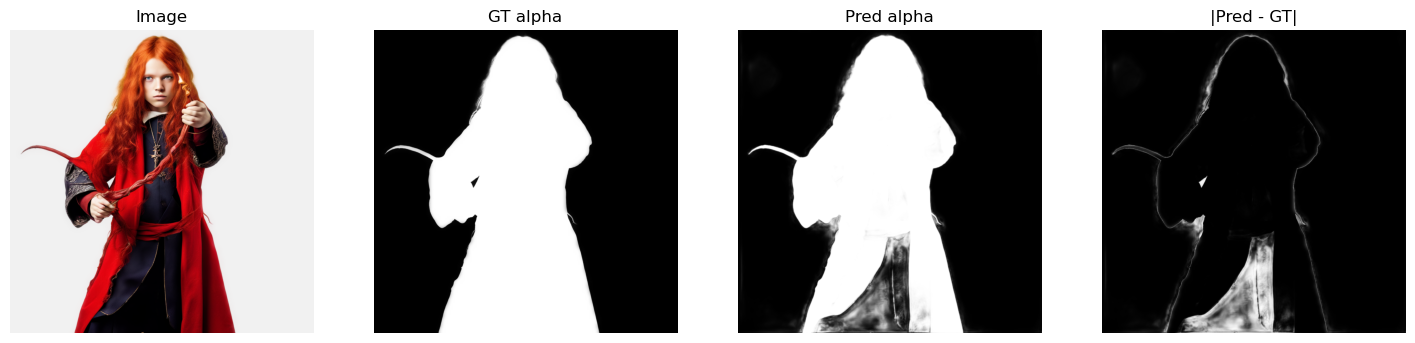

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def denorm_img(x):
    # x: [3,H,W] в [-1,1] -> [H,W,3] в [0,1]
    x = x.detach().cpu()
    x = (x * 0.5 + 0.5).clamp(0, 1)
    return x.permute(1, 2, 0).numpy()

@torch.no_grad()
def predict_alpha(model, img_tensor):
    # img_tensor: [1,3,H,W]
    outputs = model(img_tensor)
    out0 = outputs[0] if isinstance(outputs, (list, tuple)) else outputs
    # ИСПРАВЛЕНО: Модель U2NETP уже применяет sigmoid в forward
    # probs = torch.sigmoid(out0)  # СТАРЫЙ КОД с двойным sigmoid
    probs = out0  # [1,1,H,W] in [0,1] - модель уже вернула вероятности
    return probs

def show_val_examples(model, val_loader, n=3):
    model.eval()
    batch = next(iter(val_loader))
    imgs = batch["img"].to(device)
    gts  = batch["mask"].to(device)

    preds = predict_alpha(model, imgs)

    B = imgs.size(0)
    n = min(n, B)

    for i in range(n):
        img_np = denorm_img(imgs[i])
        gt_np  = gts[i,0].detach().cpu().numpy()
        pr_np  = preds[i,0].detach().cpu().numpy()
        print("GT  min/max/mean:", gt_np.min(), gt_np.max(), gt_np.mean())
        print("Pred min/max/mean:", pr_np.min(), pr_np.max(), pr_np.mean())

        diff   = np.abs(pr_np - gt_np)

        fig, axes = plt.subplots(1, 4, figsize=(18, 5))
        axes[0].imshow(img_np)
        axes[0].set_title("Image")
        axes[0].axis("off")

        axes[1].imshow(gt_np, cmap="gray", vmin=0, vmax=1)
        axes[1].set_title("GT alpha")
        axes[1].axis("off")

        axes[2].imshow(pr_np, cmap="gray", vmin=0, vmax=1)
        axes[2].set_title("Pred alpha")
        axes[2].axis("off")

        axes[3].imshow(diff, cmap="gray")
        axes[3].set_title("|Pred - GT|")
        axes[3].axis("off")

        plt.show()

# запуск после обучения:
show_val_examples(model, val_loader, n=3)


## 8. Инференс на Kaggle test + submission.csv

In [ ]:
model.eval()

test_dataset = TestImageDataset(TEST_ROOT, size=(1024, 1024))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

rows = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="test", leave=False):
        imgs = batch["img"].to(device)
        names = batch["path"]
        outputs = model(imgs)
        out0 = outputs[0] if isinstance(outputs, (list, tuple)) else outputs
        # ИСПРАВЛЕНО: Модель U2NETP уже применяет sigmoid в forward,
        # поэтому out0 уже содержит вероятности [0,1]
        probs = out0  # Убрали torch.sigmoid()
        
        # Калибровка фона по нижнему процентилю (сохраняет мягкие края)
        pred = probs[0,0].cpu().numpy().astype(np.float32)  # [H, W] в диапазоне [0, 1]
        
        # Оценка фона как 1-й процентиль
        bg = np.percentile(pred, 1)
        
        # Сдвиг так, чтобы фон → 0, но края остаются мягкими
        pred_calibrated = (pred - bg) / (1.0 - bg + 1e-6)
        pred_calibrated = np.clip(pred_calibrated, 0, 1)
        
        # Опционально: gamma коррекция для более аккуратных краёв
        pred_calibrated = pred_calibrated ** 1.3
        
        # Конвертация в uint8
        mask = (pred_calibrated * 255).astype(np.uint8)

        print(mask.shape)
        pil_mask = Image.fromarray(mask, mode="L")
        buf = io.BytesIO()
        pil_mask.save(buf, format="PNG")
        image_utf = base64.b64encode(buf.getvalue()).decode("utf-8")
        rows.append({"filename": names[0].split(".")[0], "image_utf": image_utf})

submission = pd.DataFrame(rows)
submission_path = MODEL_DIR / "submission.csv"
submission.to_csv(submission_path, index=False)
print(f"Saved submission to {submission_path}")



test:   0%|          | 0/100 [00:00<?, ?it/s]

(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)
(1024, 1024)

Загружено строк: 100
Колонки: ['filename', 'image_utf']
Первые 3 filename: [1, 2, 3]

[1] 1: shape=(1024, 1024), dtype=uint8, min=0, max=254

[2] 2: shape=(1024, 1024), dtype=uint8, min=0, max=255

[3] 3: shape=(1024, 1024), dtype=uint8, min=0, max=254


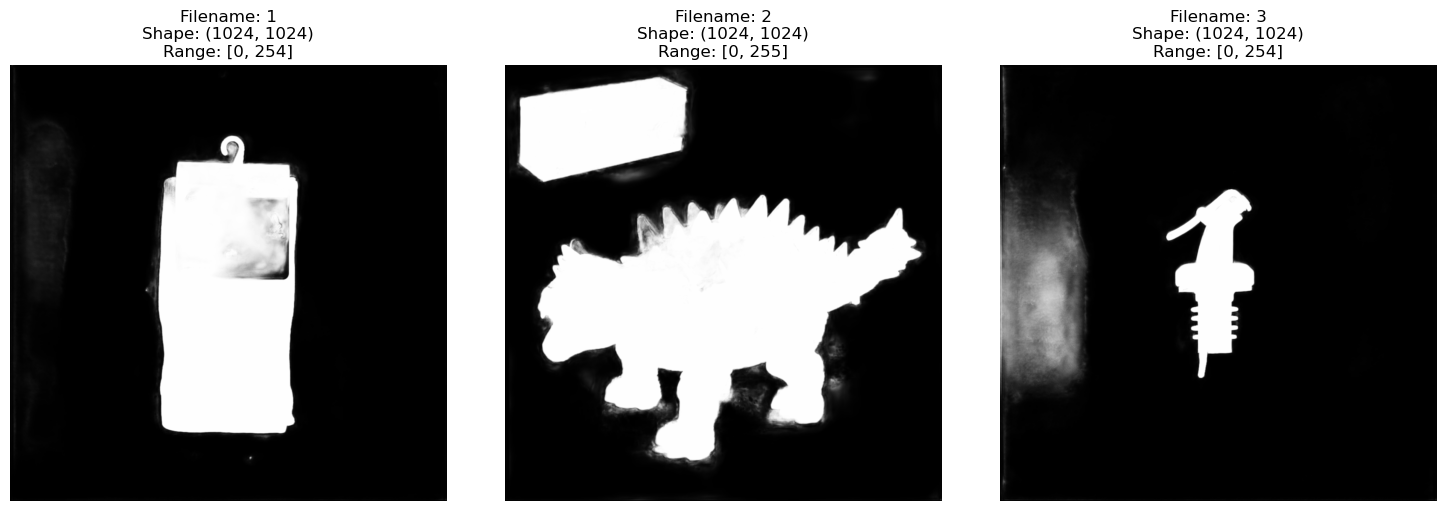


Успешно декодировано и визуализировано 3 изображений из submission.csv


In [ ]:
# Визуализация submission.csv - декодирование и отображение предсказанных масок
import base64
import io
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

# Путь к submission файлу
submission_path = Path("outputs/experiments/exp_001/submission.csv")
# submission_path = Path("data/example_submission.csv")

if not submission_path.exists():
    print(f"Файл не найден: {submission_path}")
else:
    df = pd.read_csv(submission_path)
    print(f"Загружено строк: {len(df)}")
    print(f"Колонки: {df.columns.tolist()}")
    print(f"Первые 3 filename: {df.head(3)['filename'].tolist()}")

    def decode_png(b64):
        """Декодирует base64 строку в PIL Image"""
        data = base64.b64decode(b64)
        im = Image.open(io.BytesIO(data))
        im.load()
        return im

    # Визуализация первых N изображений
    n_show = min(3, len(df))
    fig, axes = plt.subplots(1, n_show, figsize=(5 * n_show, 5))
    
    if n_show == 1:
        axes = [axes]
    
    for i in range(n_show):
        fn = df.loc[i, "filename"]
        b64 = df.loc[i, "image_utf"]
        
        try:
            im = decode_png(b64)
            arr = np.array(im)
            
            axes[i].imshow(arr, cmap="gray", vmin=0, vmax=255)
            axes[i].set_title(f"Filename: {fn}\nShape: {arr.shape}\nRange: [{arr.min()}, {arr.max()}]")
            axes[i].axis("off")
            
            print(f"\n[{i+1}] {fn}: shape={arr.shape}, dtype={arr.dtype}, min={arr.min()}, max={arr.max()}")
        except Exception as e:
            print(f"Ошибка при декодировании {fn}: {e}")
            axes[i].text(0.5, 0.5, f"Error:\n{str(e)}", ha="center", va="center")
            axes[i].axis("off")
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nУспешно декодировано и визуализировано {n_show} изображений из submission.csv")

